# Auxilliary Tutorial 5: Principal Component Analysis (PCA)
*This tutorial was prepared by Manuel Razo-Mejia and was generated from an Jupyter notebook.  You can download the notebook [here](r5_pca.ipynb).*

In [180]:
import warnings

# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy.stats as st

# Import pyplot for plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Seaborn, useful for graphics
import seaborn as sns

# Package to perform PCA
from sklearn.datasets import load_iris #Function to import the Iris dataset
import sklearn.decomposition

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline.  There is a bug, so uncomment if it works.
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

In this tutorial, we will learn about a technique known as _Principal Component Analysis_, or PCA.

[Lior Patcher](https://math.berkeley.edu/~lpachter/) has a fantastic [blog entry](https://liorpachter.wordpress.com/2014/05/26/what-is-principal-component-analysis/) explaining the details behind PCA. There Lior gives 3 alternative definitions of What PCA is:
1. An affine subspace closest to a set of points.
2. A generalization of linear regression in which the Gaussian noise is isotropic.
3. An orthogonal projection of points onto an affine space that maximizes the retained sample variance.

Although the mathematical rigor behind each definition is extremely beautiful, it is impossible for me to give a better explanation that the one given in his blog entry. For our purposes we will be sloppy and think of PCA as a projection of high dimensional data into a lower dimension space where each dimension is formed by a linear combination of the original dimensions.

We will use one of the most famous datasets available online. This data set, collected by Edgar Anderson and popularized by the one and only [Ronald Fisher](https://en.wikipedia.org/wiki/Ronald_Fisher), contains the petal and sepal lenght and width in three different species of Iris (*Iris setosa, Iris virginica and Iris versicolor*).

To give you an idea of how popular this data set is I can tell you that it has its own [Wikipedia entry](https://en.wikipedia.org/wiki/Iris_flower_data_set), you can import it with [seaborn](http://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.pairplot.html?highlight=iris), [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html) or even with pandas using

`df = pd.read_csv(
    filepath_or_buffer='https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data',
    header=None,
    sep=',')`.

For this tutorial we will import it using `scikit-learn` and transform it into a tidy data frame.

In [93]:
# Import the Iris dataset and convert it into a Pandas Data Frame
iris = load_iris()
# print(iris.DESCR) # Uncomment if you want to print the dataset description
df_iris = pd.DataFrame(iris.data, columns=iris.feature_names)
df_iris['species'] = iris.target_names[iris.target]
df_iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


We can do some exploratory analysis using seaborn `pairplot` to make pairwise comparisons between the measurements.

/Users/razo/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


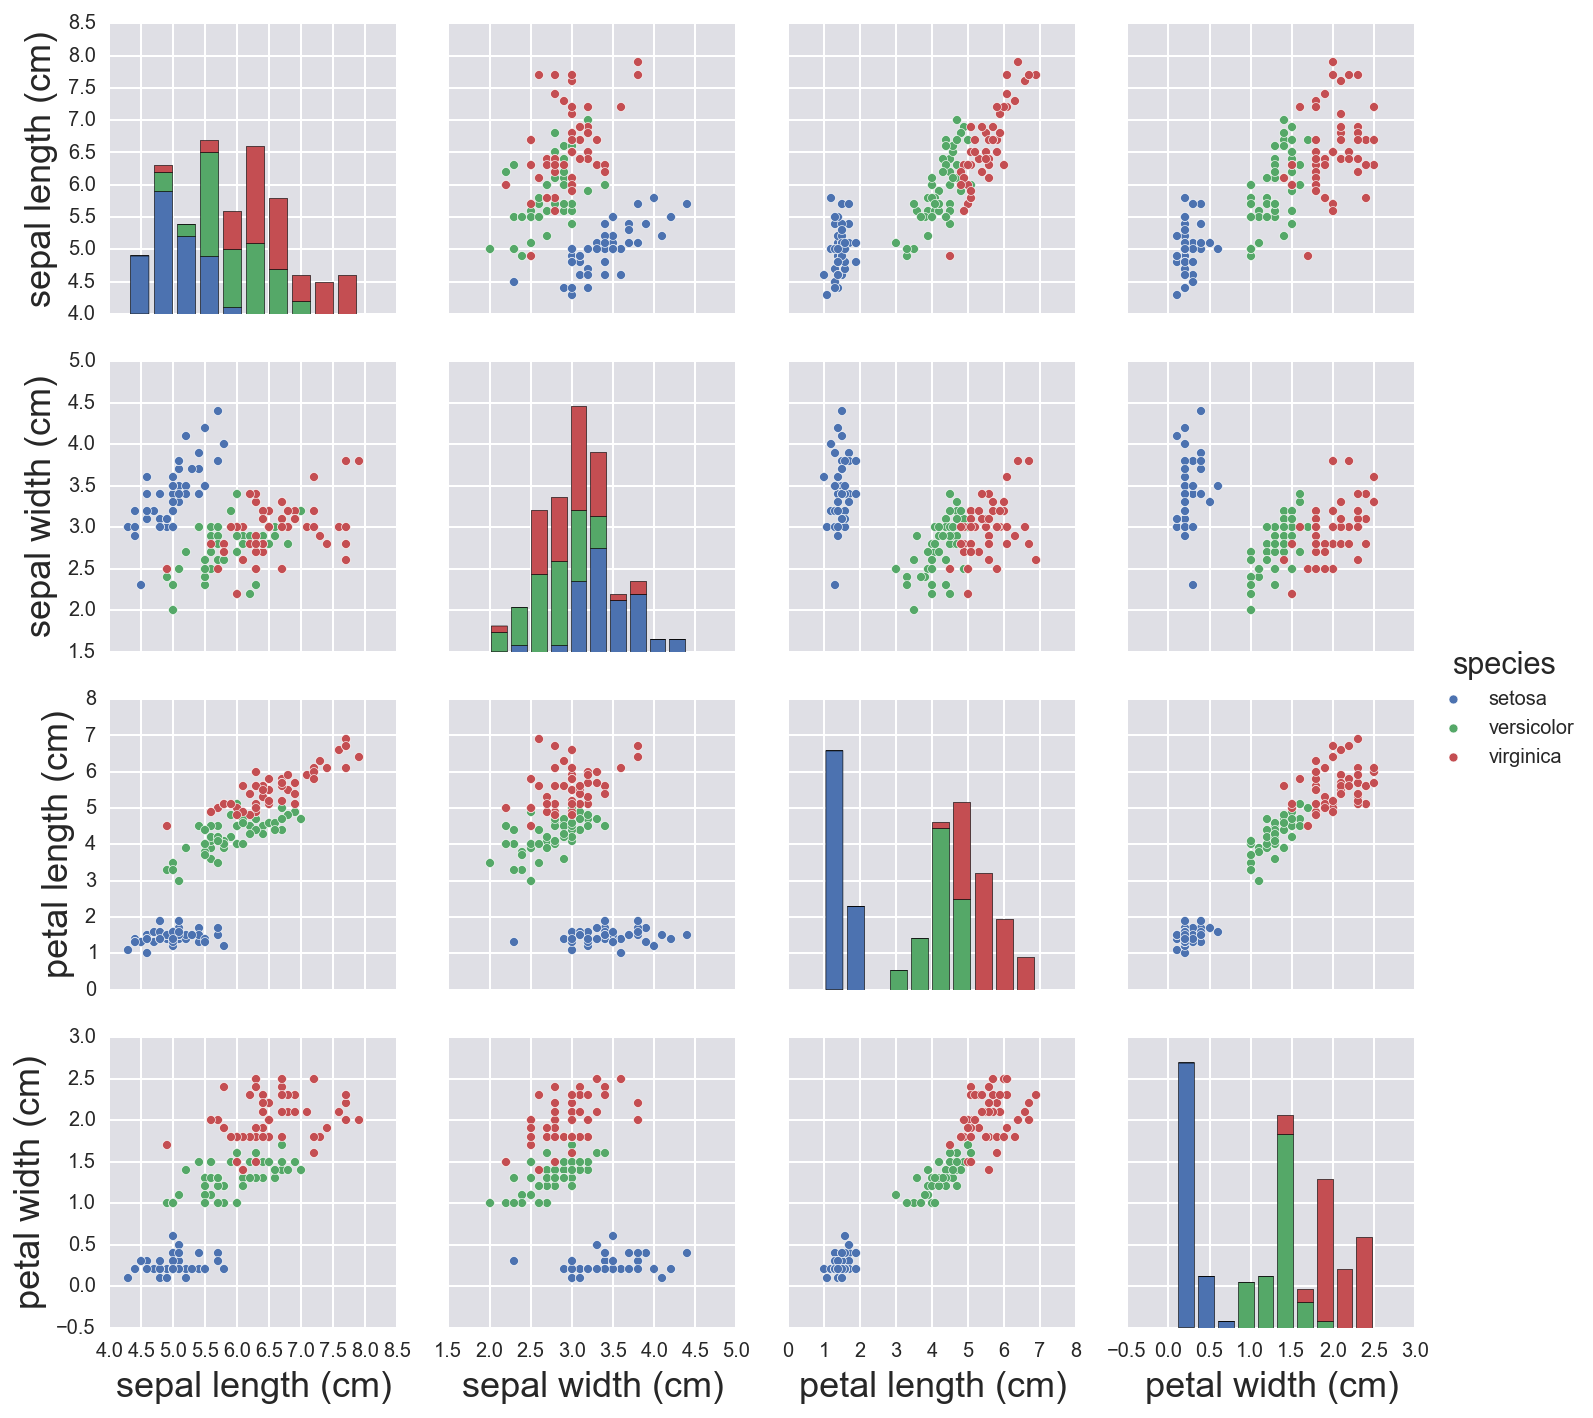

In [39]:
# Plot pairwise comparison to explore the data
_ = sns.pairplot(df_iris, hue='species')

Right away from this plot we can notice that *versicolor* and *virginica* are more similar between them than setosa.

Another thing we can notice right away is that there is a strong correlation between *petal length* and *petal width*. We can use this to explain the concept behind PCA. So let's focus on these two parameters.

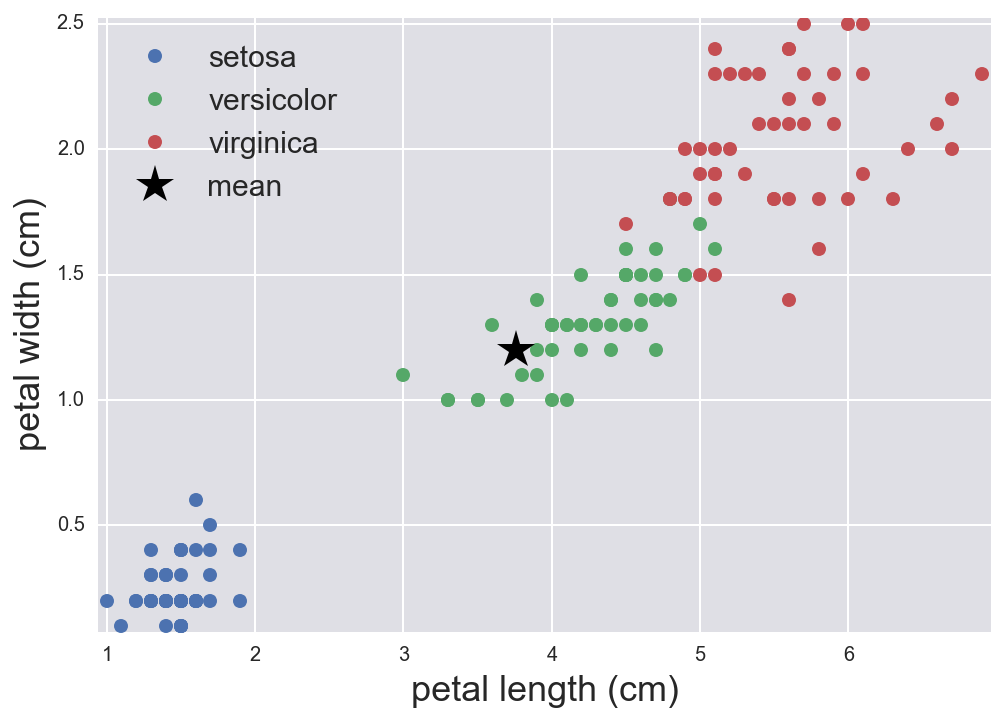

In [232]:
# Compute the mean
m = np.array([df_iris['petal length (cm)'].mean(), 
         df_iris['petal width (cm)'].mean()])

# Plot Petal length vs petal width only
for key, group in df_iris.groupby(['species']):
    plt.plot(group['petal length (cm)'], group['petal width (cm)'],
               label=key, marker='o', linestyle='none')
# Add the mean value to the plot
plt.plot(m[0], m[1],
         marker='*', color='black', markersize=20,
         linestyle='none', label='mean')
plt.legend(loc=0, fontsize=15)
plt.margins(0.01)
plt.xlabel('petal length (cm)')
plt.ylabel('petal width (cm)')

To perform PCA in python is as simple as a one-line command from `scikit-learn`. But in order to ilustrate the procedure we will compute it "*manually*" using an [eigendecomposition](https://en.wikipedia.org/wiki/Eigendecomposition_of_a_matrix).

1) Generate a dataframe centered at the mean

In [87]:
df_centered = df_iris[['petal length (cm)', 'petal width (cm)']]
df_centered['petal length (cm)'] = df_centered['petal length (cm)'] - \
                                   df_centered['petal length (cm)'].mean()
df_centered['petal width (cm)'] = df_centered['petal width (cm)'] - \
                                   df_centered['petal width (cm)'].mean()
df_centered.head()

/Users/razo/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/razo/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,petal length (cm),petal width (cm)
0,-2.358667,-0.998667
1,-2.358667,-0.998667
2,-2.458667,-0.998667
3,-2.258667,-0.998667
4,-2.358667,-0.998667


2) Compute the covariance matrix

In [89]:
cov_mat = np.cov(m=df_centered.transpose())
print('Covariance matrix \n%s'%cov_mat)

Covariance matrix 
[[ 3.11317942  1.29638747]
 [ 1.29638747  0.58241432]]


3) Perform an eigenvalue decomposition of the covariance matrix.

We won't cover the math behind this procedure. It is enough to say that the *Principal Components* directions are given by the eigenvectors of the matrix and the magnitude of such components are given by the eigenvalues.

Most of the available algorithms to do PCA use [singular value decomposition](https://en.wikipedia.org/wiki/Singular_value_decomposition) instead for computational efficiency. But regardless of the algorithm the objective is still the same: compute the eigenvectors and eigenvalues from the covariance matrix.

In [90]:
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[ 0.92154695 -0.38826694]
 [ 0.38826694  0.92154695]]

Eigenvalues 
[ 3.65937449  0.03621925]


We can plot these eigenvectors on top of our scatter plot to get some intuition of what do they mean

/Users/razo/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


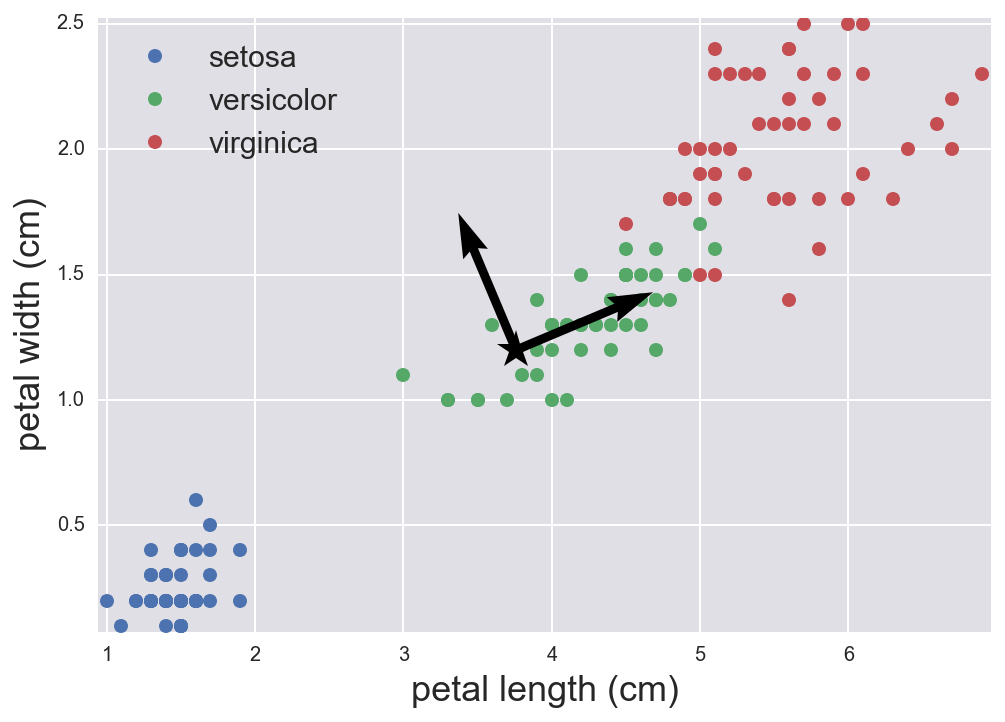

In [122]:
# Plot Petal length vs petal width only
for key, group in df_iris.groupby(['species']):
    plt.plot(group['petal length (cm)'], group['petal width (cm)'],
               label=key, marker='o', linestyle='none')
# Add the mean value to the plot
plt.plot(m[0], 
         m[1],
         marker='*', color='black', markersize=20)

# Add arros showing the eigenvectors
for i in range(np.shape(eig_vecs)[1]):
    plt.quiver(m[0],m[1],
               eig_vecs[0,i],
               eig_vecs[1,i],
               zorder=11,
               width=0.01, scale=6)

plt.legend(loc=0, fontsize=15)
plt.margins(0.01)
plt.xlabel('petal length (cm)')
plt.ylabel('petal width (cm)')

As explained in [this incredibly useful blog](http://sebastianraschka.com/Articles/2015_pca_in_3_steps.html#Preparing-the-Iris-Dataset) that actually uses the same data set:

"*The eigenvectors (principal components) determine the directions of the new feature space, and the eigenvalues determine their magnitude. In other words, the eigenvalues explain the variance of the data along the new feature axes*".

We chose this pair of measurements originally because there was a clear correlation between them. This is indeed confirmed by the magnitude of the *eigenvalues* where one of them is two orders of magnitude larger than the other.

Lior's blog explains with exquisite detail how we can think of PCA as *an orthogonal projection of points onto an affine space that maximizes the retained sample variance*.
What this is saying is that when we project our high dimensional data into a lower dimension space PCA does it such that *the **sample variance** of the projections of the observed points onto this subspace is **maximized** *.

In other words if we sort the principal components in decreasing order according to their corresponding eigenvalues the components with the largest eigenvalues explain more of the variability in the data.
This can be precisely computed as the explained variance. This explained variance tells us how much information (variance) can be attributed to each of the principal components.

So we can easily compute how much variability is explained by each of the two principal components.

In [127]:
# Compute how much variance is explained by each principal component
print('PCA 1: %s percent of the variance'%round(eig_vals[0] / np.sum(eig_vals) \
                                                * 100, 2))
print('PCA 2: %s percent of the variance'%round(eig_vals[1] / np.sum(eig_vals) \
                                                * 100, 2))


PCA 1: 99.02 percent of the variance
PCA 2: 0.98 percent of the variance


From this we can see from this that if we were to project this 2D data into a 1D space we would be able to explain almost all the variability within the data.

To actually project our data into this subspace we have to multiply our data by the so-called projection matrix.
But don't get tangled with the names; if we want to project our data into a $ k $ dimension space, this matrix is just our top * k * eigenvectors concatenated.

Since in this simple example we are projecting into a 1D space we basically have to multiply our data by the eigenvector with the largest corresponding eigenvalue.

In [148]:
# Project data to our 1D space
df_1D['projection'] = pd.DataFrame(df_iris[['petal length (cm)',\
                              'petal width (cm)']].dot(eig_vecs[:,0]))
df_1D['species'] = df_iris['species']

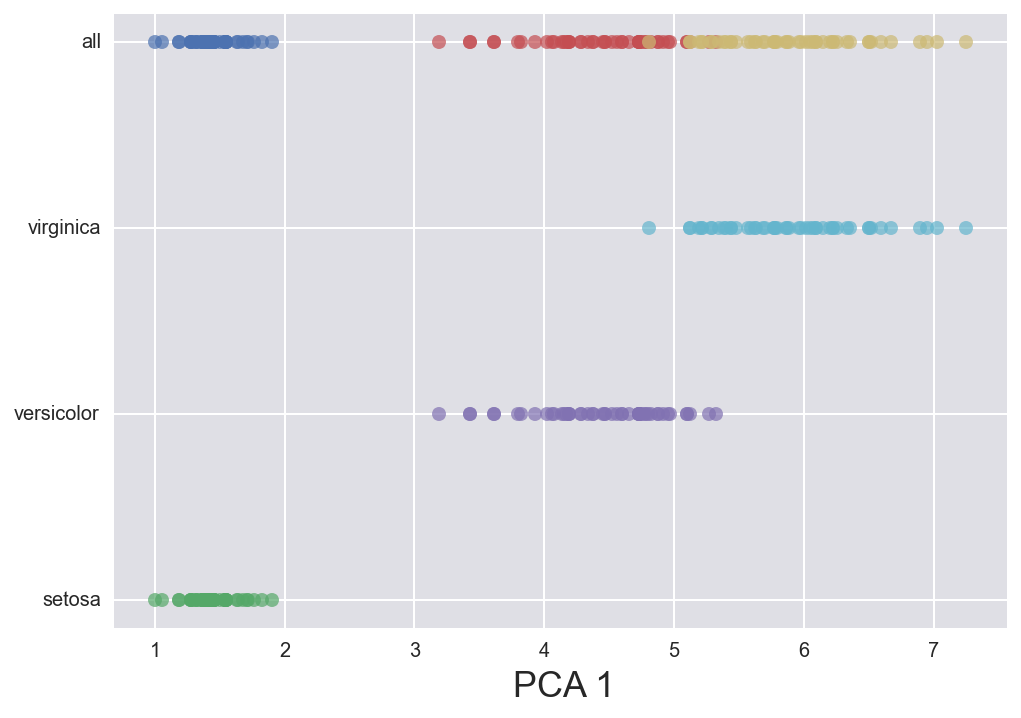

In [178]:
for key, group in df_1D.groupby(['species']):
    plt.plot(group['projection'], np.ones(len(group)) * 3, alpha=0.7,
             label=key, marker='o', linestyle='none')
    group_num = int(np.where(iris.target_names == key)[0])
    plt.plot(group['projection'], np.ones(len(group)) * group_num, alpha=0.7,
             marker='o', linestyle='none')

plt.margins(0.05)
plt.yticks(range(4), np.append(iris.target_names, 'all'))
plt.xlabel('PCA 1')

## Scikit-learn shortcut
Now that we explored step-by-step how to do PCA we can use `scikit-learn` to do it in a single line.
For this we will take the 4 dimensions of the original dataset and explore how much variability is explained by each of the resulting Principal Components.

In [197]:
# Calculate the principal components using scikit-learn
sklearn_pca = sklearn.decomposition.PCA()
sklearn_pca.fit(df_iris[iris.feature_names])
print('Variance percent explained \n %s'%sklearn_pca.explained_variance_ratio_)

Variance percent explained 
 [ 0.92461621  0.05301557  0.01718514  0.00518309]


From this we can see that the first component already captures 92% of the variability in the data!

We can easily project into a 1D, 2D or 3D space reducing the dimensionality of the data set. As an excersice lets project it into a 2D space.

In [233]:
sklearn_pca = sklearn.decomposition.PCA(n_components=2)
sklearn_pca.fit(df_iris[iris.feature_names])
print('Variance percent explained \n %s'%sklearn_pca.explained_variance_ratio_)

Variance percent explained 
 [ 0.92461621  0.05301557]


In [219]:
def pca_projection(sklearn_PCA, data, dim):
    '''
    Function to project into the number of dimensions we want without
    calculating the PCA again.
    For this we will use scikit-learn implementation of the dot product to speed
    up the process. This is useful when dealing with very large datasets.
    Parameters
    ----------
    sklearn_PCA: object of class 'sklearn.decomposition.pca.PCA' obtained from
                 performing PCA with skilit-learn
    data: array-like, shape (n_samples, n_features)
          New data, where n_samples is the number of samples 
          and n_features is the number of features.
    dim: int, number of dimensions to keep for the projection
    '''
    if np.shape(sklearn_PCA.components_)[1] < dim:
        raise ValueError('The number of dimensions cannot exceed the number of\
                         components')
    df_project = sklearn.utils.extmath.fast_dot(data, 
                                                sklearn_PCA.components_[:,:dim])
    return df_project

In [228]:
df_2D = pd.DataFrame(pca_projection(sklearn_pca, df_iris[iris.feature_names], 2))
df_2D['species'] = df_iris['species']
df_2D.head()

,0,1,species
0,0.423065,-3.873369,setosa
1,0.679017,-3.492059,setosa
2,0.417291,-3.561906,setosa
3,0.562986,-3.599991,setosa
4,0.321252,-3.938113,setosa


In [235]:
df_2D = pd.DataFrame(sklearn_pca.transform(df_iris[iris.feature_names]))
df_2D['species'] = df_iris['species']
df_2D.head()

,0,1,species
0,-2.684207,-0.326607,setosa
1,-2.715391,0.169557,setosa
2,-2.889820,0.137346,setosa
3,-2.746437,0.311124,setosa
4,-2.728593,-0.333925,setosa


Now we can plot our original 4D data into a 2D space that explains ≈ 93% of the variability.

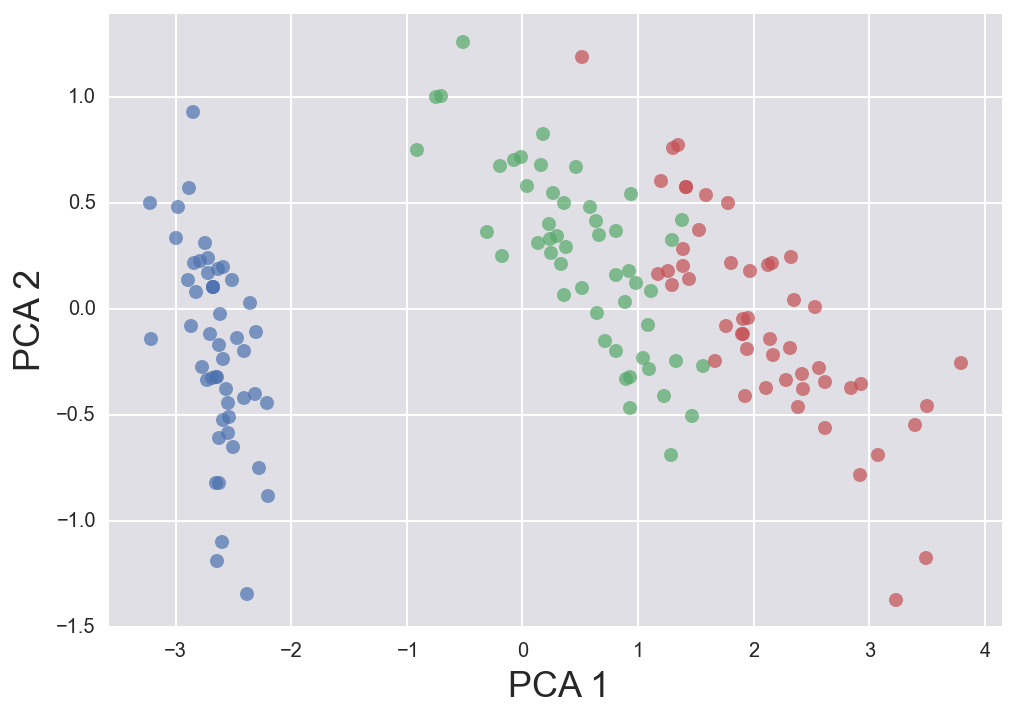

In [236]:
for key, group in df_2D.groupby(['species']):
    plt.plot(group[0], group[1], alpha=0.7,
             label=key, marker='o', linestyle='none')

plt.margins(0.05)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
